<a href="https://colab.research.google.com/github/neoyipeng2018/sgx-sent/blob/main/FinancialNLPstrat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reading and classifying boring corporate filings with NLP
1. Getting filings
1. Sentiment Labelling
1. Verify sentiments (Backtesting)

## Basics

In [ ]:
%matplotlib inline

from google.colab import drive; drive.mount('/content/gdrive', force_remount=True)
%cd '/content/gdrive/My Drive/Colab Notebooks'

import pandas as pd
import glob

Mounted at /content/gdrive
/content/gdrive/My Drive/Colab Notebooks


## Getting filings

### Downloading data
https://gist.github.com/neoyipeng2018/403acb271c14ee7dcd5dfbbe17bee2cc

### Parsing pdfs
https://stackabuse.com/working-with-pdfs-in-python-reading-and-splitting-pages/

In [ ]:
!pip install pdflib

     |████████████████████████████████| 5.8MB 6.4MB/s 


In [ ]:
dir='data/SGX/'

In [ ]:
from pdflib import Document
doc = Document(dir+"01-Apr-2020 181516_1AEM.pdf")

for page in doc:
  print(' \n'.join(page.lines).strip())

SGXNET Announcement 
AEM Holdings Ltd 
(Registration No. 200006417D) 
NOTICE OF TRANSFER OF TREASURY SHARES 
Pursuant to Rule 704(28) of the Listing Manual of the Singapore Exchange Securities Trading 
Limited, AEM Holdings Ltd wishes to announce the following transfer of treasury shares from its 
Share Buyback Account maintained with The Central Depository (Private) Limited: 
Date of transfer                                                      1 April 2020 
Pursuant to the transformational performance share award 
Purpose of transfer                             under the AEM performance share grant as announced on 
7 October 2019 
Number of treasury shares transferred                                    433,667 
Number of treasury shares held before transfer                          2,440,980 
Number of treasury shares held after transfer                           2,007,313 
Percentage of the number of treasury shares 
against the total number of ordinary shares                       

In [ ]:
pdfs = glob.glob(dir+'*AEM.pdf')
pdfs[:5]

['data/SGX/14-Oct-2020 201548_1AEM.pdf',
 'data/SGX/02-Oct-2020 180219_1AEM.pdf',
 'data/SGX/29-Sep-2020 181752_1AEM.pdf',
 'data/SGX/17-Sep-2020 065825_1AEM.pdf',
 'data/SGX/10-Sep-2020 183408_1AEM.pdf']

In [ ]:
for f in pdfs:
  doc = Document(f)
  for page in doc:
    print(' \n'.join(page.lines).strip())

## Extract Sentiment
- https://towardsdatascience.com/how-nlp-has-evolved-for-financial-sentiment-analysis-fb2990d9b3ed

In [ ]:
!pip install transformers

     |████████████████████████████████| 1.3MB 22.8MB/s 
     |████████████████████████████████| 1.1MB 55.2MB/s 
     |████████████████████████████████| 890kB 50.6MB/s 
     |████████████████████████████████| 2.9MB 27.6MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=9a8dbf6807720e5f383d70e0d669676d3b855ff270350376619fe648ac51ea34
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification

In [ ]:
import torch

article on tokenizers:https://towardsdatascience.com/tokenizers-nlps-building-block-9ab17d3e6929

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
model = BertForSequenceClassification.from_pretrained('finbertProsus/pytorch_model.bin',config='finbertProsus/config.json',num_labels=3)

In [ ]:
label_list=['positive','negative','neutral']

In [ ]:
inputs = tokenizer("We did badly this quarter", return_tensors="pt")
outputs = model(**inputs)
label_list[torch.argmax(outputs[0])]

'negative'

In [ ]:
inputs = tokenizer("We did well this quarter", return_tensors="pt")
outputs = model(**inputs)
label_list[torch.argmax(outputs[0])]

'positive'

In [ ]:
inputs = tokenizer("We did meh this quarter", return_tensors="pt")
outputs = model(**inputs)
label_list[torch.argmax(outputs[0])]

'neutral'

In [ ]:
sentLs=[]
for f in pdfs:

  doc = Document(f)

  sentSum=0
  for page in doc:
    txt=' \n'.join(page.lines).strip()
    inputs = tokenizer(txt, return_tensors="pt",max_length=512,truncation=True)
    outputs = model(**inputs)
    sent=torch.argmax(outputs[0])
    if sent==0: sentSum+=1
    elif sent==1: sentSum-=1
  
  sentLs.append(sentSum)


In [ ]:
assert len(sentLs)==len(pdfs)

In [ ]:
df=pd.DataFrame()
df['sent']=sentLs
df['file']=pdfs
df.head()

,sent,file
0,0,data/SGX/14-Oct-2020 201548_1AEM.pdf
1,0,data/SGX/02-Oct-2020 180219_1AEM.pdf
2,0,data/SGX/29-Sep-2020 181752_1AEM.pdf
3,0,data/SGX/17-Sep-2020 065825_1AEM.pdf
4,0,data/SGX/10-Sep-2020 183408_1AEM.pdf


In [ ]:
import re

In [ ]:
dtLs=[]
for f in pdfs:
  dt=re.findall(r'\d{2}-\w{3}-\d{4}',f)[0]
  dtLs.append(dt)

In [ ]:
len(dtLs)

150

In [ ]:
df['date']=dtLs
df.head(2)

,sent,file,date
0,0,data/SGX/14-Oct-2020 201548_1AEM.pdf,14-Oct-2020
1,0,data/SGX/02-Oct-2020 180219_1AEM.pdf,02-Oct-2020


In [ ]:
df.dtypes

sent     int64
file    object
date    object
dtype: object

In [ ]:
df['date']=pd.to_datetime(df['date'])
df.set_index('date',inplace=True)
df.head(2)

,sent,file
date,,
2020-10-14,0,data/SGX/14-Oct-2020 201548_1AEM.pdf
2020-10-02,0,data/SGX/02-Oct-2020 180219_1AEM.pdf


In [ ]:
sent=df.groupby(df.index).sent.sum()
sent.head(2)

date
2020-04-01    0
2020-04-08    0
Name: sent, dtype: int64

In [ ]:
sent.sort_values(ascending=False)[:10]

date
2020-08-03    10
2020-04-15     8
2020-04-28     4
2020-05-20     4
2020-08-24     2
2020-07-22     2
2020-06-09     2
2020-04-19     2
2020-05-21     2
2020-05-14     0
Name: sent, dtype: int64

In [ ]:
sent

date
2020-04-01    0
2020-04-08    0
2020-04-09    0
2020-04-13    0
2020-04-15    8
             ..
2020-09-29    0
2020-09-30    0
2020-10-01    0
2020-10-02    0
2020-10-14    0
Name: sent, Length: 70, dtype: int64

## Backtesting
https://backtrader.com/docu/quickstart/quickstart/

In [ ]:
!pip install backtrader

     |████████████████████████████████| 419kB 10.7MB/s 


In [ ]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

import datetime  # For datetime objects
import os.path  # To manage paths
import sys  # To find out the script name (in argv[0])

# Import the backtrader platform
import backtrader as bt


# Create a Stratey
class TestStrategy(bt.Strategy):
    params = (
        ('exitbars', 0),
    )

    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close
        self.datasent = self.datas[0].sent

        # To keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.buycomm = None

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))

    def next(self):
        # Simply log the closing price of the series from the reference
        self.log('Close, %.2f' % self.dataclose[0])

        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

        # Check if we are in the market
        if not self.position:

            # Not yet ... we MIGHT BUY if ...
            if self.datasent[0] >2:
              # BUY, BUY, BUY!!! (with default parameters)
              self.log('BUY CREATE, %.2f' % self.dataclose[0])

              # Keep track of the created order to avoid a 2nd order
              self.order = self.buy()

        else:

            # Already in the market ... we might sell
            if len(self) >= (self.bar_executed + self.params.exitbars):
                # SELL, SELL, SELL!!! (with all possible default parameters)
                self.log('SELL CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell()



In [ ]:
yf=pd.read_csv(dir+'AWX_SI.csv')
yf.Date=pd.to_datetime(yf['Date'])
yf.set_index('Date',inplace=True)

comb=yf.merge(sent,left_index=True,right_index=True,how='left').fillna(0)
comb.head(2)

,Open,High,Low,Close,Adj Close,Volume,sent
Date,,,,,,,
2020-01-02,2.04,2.10,2.04,2.09,2.023888,9308500,0.0
2020-01-03,2.10,2.12,2.04,2.04,1.975469,7326800,0.0


In [ ]:
class PandasSent(bt.feeds.PandasData):
  lines=(('sent'),)
  params=(('sent',-1),)

In [ ]:
if __name__ == '__main__':
    # Create a cerebro entity
    cerebro = bt.Cerebro()

    # Add a strategy
    cerebro.addstrategy(TestStrategy)

    data = PandasSent(dataname=comb)

    # Add the Data Feed to Cerebro
    cerebro.adddata(data)

    # Set our desired cash start
    cerebro.broker.setcash(100000.0)

    # Add a FixedSize sizer according to the stake
    cerebro.addsizer(bt.sizers.FixedSize, stake=100)

    # Set the commission - 0.1% ... divide by 100 to remove the %
    cerebro.broker.setcommission(commission=0.001)

    # Print out the starting conditions
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Run over everything
    cerebro.run()

    # Print out the final result
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 100000.00
2020-01-02, Close, 2.09
2020-01-03, Close, 2.04
2020-01-06, Close, 1.98
2020-01-07, Close, 2.04
2020-01-08, Close, 2.00
2020-01-09, Close, 2.05
2020-01-10, Close, 2.18
2020-01-13, Close, 2.19
2020-01-14, Close, 2.16
2020-01-15, Close, 2.16
2020-01-16, Close, 2.18
2020-01-17, Close, 2.16
2020-01-20, Close, 2.13
2020-01-21, Close, 2.08
2020-01-22, Close, 2.13
2020-01-23, Close, 2.05
2020-01-24, Close, 2.11
2020-01-28, Close, 2.01
2020-01-29, Close, 2.02
2020-01-30, Close, 1.93
2020-01-31, Close, 1.90
2020-02-03, Close, 1.89
2020-02-04, Close, 1.95
2020-02-05, Close, 1.94
2020-02-06, Close, 1.96
2020-02-07, Close, 1.87
2020-02-10, Close, 1.88
2020-02-11, Close, 1.95
2020-02-12, Close, 2.01
2020-02-13, Close, 2.04
2020-02-14, Close, 2.06
2020-02-17, Close, 2.14
2020-02-18, Close, 2.17
2020-02-19, Close, 2.22
2020-02-20, Close, 2.27
2020-02-21, Close, 2.23
2020-02-24, Close, 2.09
2020-02-25, Close, 2.21
2020-02-26, Close, 2.17
2020-02-27, Close, 2.24
2020

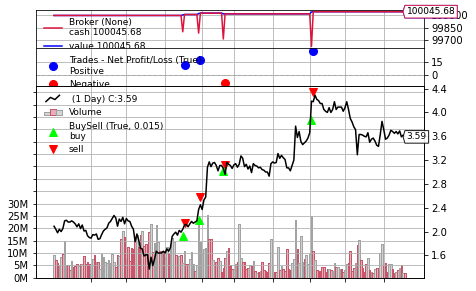

[[<Figure size 432x288 with 4 Axes>]]

In [ ]:
cerebro.plot(iplot=False)

In [ ]:
sent.sort_values(ascending=False)[:10]

date
2020-08-03    10
2020-04-15     8
2020-04-28     4
2020-05-20     4
2020-08-24     2
2020-07-22     2
2020-06-09     2
2020-04-19     2
2020-05-21     2
2020-05-14     0
Name: sent, dtype: int64